Starting single-core Monte Carlo Simulation with full flow dynamics up to l=10...
Number of runs: 125000


Flow Sim: 100%|████████████████████████| 125000/125000 [14:02<00:00, 148.28it/s]
/tmp/ipykernel_241735/1637826213.py:146: RuntimeWarning: divide by zero encountered in divide
  ns_line = 1 - (2 * r_line) / (16 - r_line)



Simulation complete. Generated 114173 valid data points.
Plot saved as ns_r_plot_l10_dynamics.png


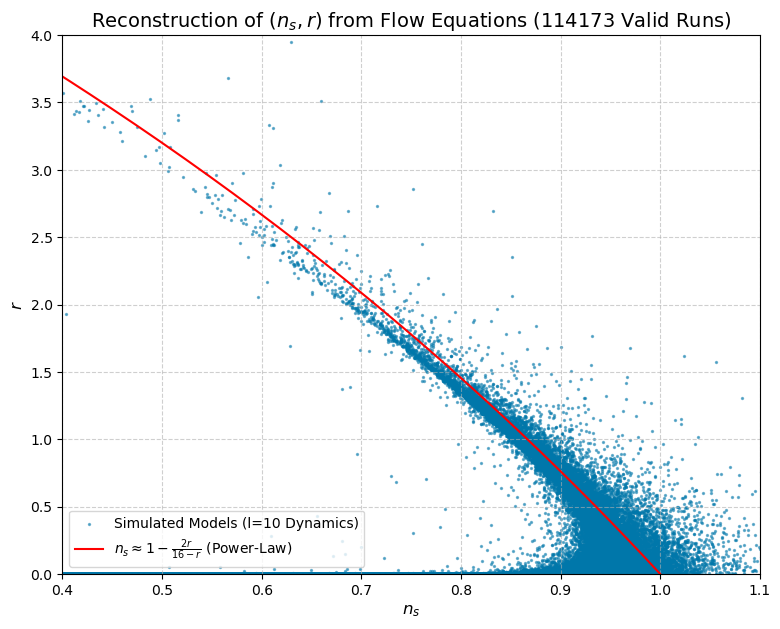

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- 1. User-Specified and Core Parameters ---
# Reverting to single-core execution to avoid pickling errors
N_RUNS = 125000                  # Number of stochastic realizations (Increased for better scatter visualization)
N_OBS = 55                      # E-folds before end of inflation (Observational point)
N_CRITICAL = 200                # E-fold cut-off for "asymptotic" flows
C_CONST = 0.0814514             # Constant in the second-order relations

print("Starting single-core Monte Carlo Simulation with full flow dynamics up to l=10...")
print(f"Number of runs: {N_RUNS}")

# Initial Condition Ranges (Uniform Distributions)
# y = [epsilon, sigma, lambda_H_2, lambda_H_3, ..., lambda_H_10] (10 components)
EPSILON_RANGE = (0.0, 0.8)
SIGMA_RANGE = (-0.5, 0.5)
XI_RANGE = (-0.05, 0.05) # lambda_H_2

# Lambda_H_l ranges for l >= 3
def get_lambda_range(l):
    # Range: [-0.025 * 5^(-l+3), 0.025 * 5^(-l+3)]
    scale = 5**(-l + 3)
    return (-0.025 * scale, 0.025 * scale)

# --- 2. Inflattionary Flow Equations (ODE System) ---
def flow_equations(N, y):
    """
    The dynamics of the flow parameters (10 components).
    y = [epsilon, sigma, lambda_H_2, ..., lambda_H_10]
    """
    # Unpack the state vector
    epsilon = y[0]
    sigma = y[1]
    lambda_H = y[2:] # lambda_H_l for l=2 to 10 (8 components)
    
    dy_dN = np.zeros_like(y)
    
    # 1. d(epsilon)/dN
    dy_dN[0] = epsilon * (sigma + 2 * epsilon)
    
    # 2. d(sigma)/dN
    # lambda_H_2 is y[2] or lambda_H[0]
    dy_dN[1] = -epsilon * (5 * sigma + 12 * epsilon) + 2 * lambda_H[0]
    
    # 3. d(lambda_H_l)/dN for l = 2 to 9 (indices 2 to 9 in y, 0 to 7 in lambda_H)
    for i in range(len(lambda_H) - 1): # i=0 is l=2, i=7 is l=9
        l = i + 2
        # d(lambda_H_l)/dN = [(l-1)/2 * sigma + (l-2) * epsilon] * lambda_H_l + lambda_H_(l+1)
        term1 = ((l - 1) / 2) * sigma + (l - 2) * epsilon
        dy_dN[i + 2] = term1 * lambda_H[i] + lambda_H[i + 1]
        
    # 4. d(lambda_H_10)/dN (index 10 in y, 8 in lambda_H)
    # lambda_H_11 = 0 (Truncation)
    l = 10
    term1 = ((l - 1) / 2) * sigma + (l - 2) * epsilon
    dy_dN[-1] = term1 * lambda_H[-1]
    
    return dy_dN

# --- 3. Run Termination Condition ---
def end_of_inflation(N, y):
    """Event function to stop integration when epsilon = 1."""
    return y[0] - 1.0

end_of_inflation.terminal = True
end_of_inflation.direction = 1

# --- 4. Monte Carlo Simulation (Single-core with tqdm) ---

ns_results = []
r_results = []

for i in tqdm(range(N_RUNS), desc="Flow Sim"):
    
    # a) Generate independent initial conditions for this run (10 components)
    epsilon_0 = np.random.uniform(*EPSILON_RANGE)
    sigma_0 = np.random.uniform(*SIGMA_RANGE)
    xi_0 = np.random.uniform(*XI_RANGE)
    
    # Initialize higher-order lambda_H (l=3 to 10)
    lambda_H_l = [np.random.uniform(*get_lambda_range(l)) for l in range(3, 11)]
    
    # y_initial = [epsilon, sigma, lambda_H_2, lambda_H_3, ..., lambda_H_10]
    y_initial = [epsilon_0, sigma_0, xi_0] + lambda_H_l

    # b) Evolve flow forward in N (backward in time)
    try:
        sol = solve_ivp(
            flow_equations, 
            (0, N_CRITICAL), 
            y_initial, 
            events=end_of_inflation,
            dense_output=True,
            rtol=1e-8, atol=1e-8
        )
    except Exception:
        continue # Skip run on numerical error
    
    # c) Determine the Observation Point
    N_end = N_CRITICAL
    if sol.status == 1 and len(sol.t_events[0]) > 0:
        # Case 1: Slow-roll violation (epsilon=1)
        N_end = sol.t_events[0][0]
    
    N_obs_point = N_end - N_OBS
    
    # d) Calculate Observables
    if N_obs_point > sol.t[0] and N_obs_point < N_end:
        y_obs = sol.sol(N_obs_point)
        
        epsilon_obs = y_obs[0]
        sigma_obs = y_obs[1]
        xi_obs = y_obs[2] # lambda_H_2
        
        # Check epsilon < 1 to ensure inflation was active at the observation point
        if epsilon_obs < 1.0:
            
            # Second-order relations (Eq. 17 and 18 in the paper)
            r = 16 * epsilon_obs * (1 - C_CONST * (sigma_obs + 2 * epsilon_obs))
            
            # ns = 1 + sigma - (5-3C)epsilon^2 - 1/4(3-5C)sigma*epsilon + 1/2(3-C)xi
            ns = (1 + sigma_obs 
                  - (5 - 3 * C_CONST) * epsilon_obs**2 
                  - 0.25 * (3 - 5 * C_CONST) * sigma_obs * epsilon_obs 
                  + 0.5 * (3 - C_CONST) * xi_obs)
            
            ns_results.append(ns)
            r_results.append(r)

# --- 5. Plotting ---

valid_runs = len(ns_results)
print(f"\nSimulation complete. Generated {valid_runs} valid data points.")

plt.figure(figsize=(9, 7))

# Scatter plot of n_s vs r (Figure 3)
plt.scatter(ns_results, r_results, s=2, alpha=0.5, color='#0077AA', label='Simulated Models (l=10 Dynamics)')

# Overplot the power-law inflation relation (Eq. 21 in the paper)
r_line = np.linspace(0.001, 16, 500)
ns_line = 1 - (2 * r_line) / (16 - r_line)
plt.plot(ns_line, r_line, color='red', linestyle='-', linewidth=1.5, label=r'$n_s \approx 1 - \frac{2r}{16-r}$ (Power-Law)')

plt.xlabel(r'$n_s$', fontsize=12)
plt.ylabel(r'$r$', fontsize=12)
plt.title(f'Reconstruction of $(n_s, r)$ from Flow Equations ({valid_runs} Valid Runs)', fontsize=14)
plt.xlim(0.4, 1.1)
plt.ylim(0, 4)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.gca().invert_yaxis()
plt.savefig('ns_r_plot_l10_dynamics.png')

print("Plot saved as ns_r_plot_l10_dynamics.png")

/tmp/ipykernel_241735/1890761609.py:8: RuntimeWarning: divide by zero encountered in divide
  ns_line = 1 - (2 * r_line) / (16 - r_line)


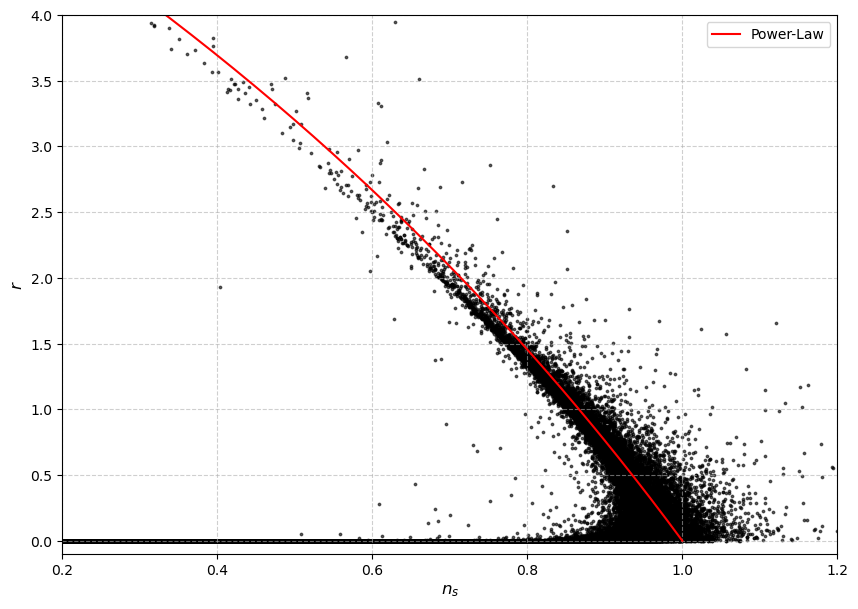

In [21]:
plt.figure(figsize=(10, 7))
# Scatter plot of n_s vs r (Figure 3)
plt.scatter(ns_results, r_results, s=3, c='black', alpha=0.6)
#lt.scatter(ns_results, r_results, marker='o', s=10, c='black', alpha=0.25)

# Overplot the power-law inflation relation (Eq. 21 in the paper)
r_line = np.linspace(0.001, 16, 500)
ns_line = 1 - (2 * r_line) / (16 - r_line)
plt.plot(ns_line, r_line, color='red', linestyle='-', linewidth=1.5, label=r'Power-Law')

plt.xlabel(r'$n_s$', fontsize=12)
plt.ylabel(r'$r$', fontsize=12)
#plt.title(f'Reconstruction of $(n_s, r)$ from Flow Equations ({valid_runs} Valid Runs)', fontsize=14)
plt.xlim(0.2, 1.2)
plt.ylim(-0.1, 4)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('ns_r_plot_M10_dynamics.pdf',transparent=True, bbox_inches='tight') 

/tmp/ipykernel_241735/1031800624.py:8: RuntimeWarning: divide by zero encountered in divide
  ns_line = 1 - (2 * r_line) / (16 - r_line)


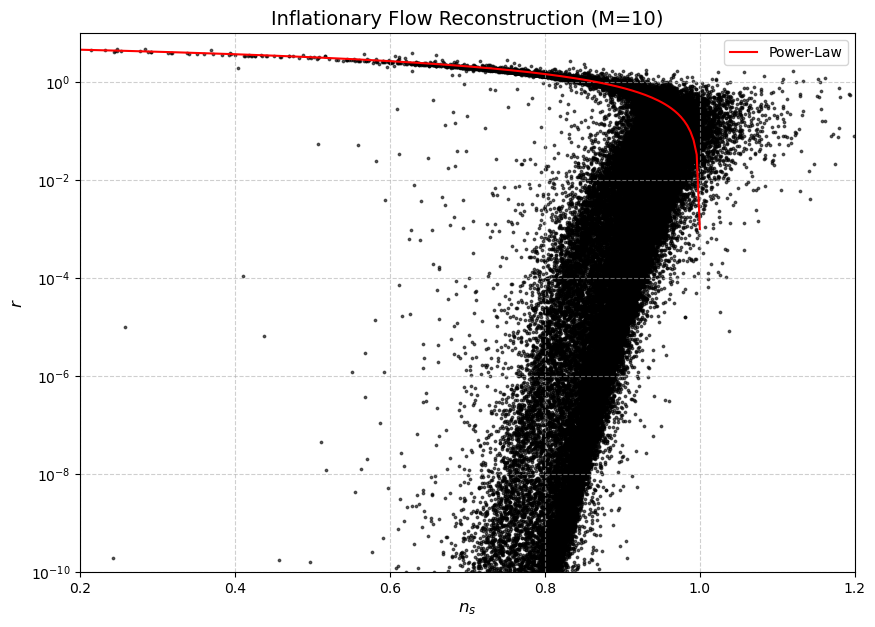

In [20]:
plt.figure(figsize=(10, 7))
# Scatter plot of n_s vs r (Figure 3)
plt.scatter(ns_results, r_results, marker='o',s=3, c='black', alpha=0.6)
#lt.scatter(ns_results, r_results, marker='o', s=10, c='black', alpha=0.25)

# Overplot the power-law inflation relation (Eq. 21 in the paper)
r_line = np.linspace(0.001, 16, 500)
ns_line = 1 - (2 * r_line) / (16 - r_line)
plt.plot(ns_line, r_line, color='red', linestyle='-', linewidth=1.5, label=r'Power-Law')

plt.xlabel(r'$n_s$', fontsize=12)
plt.ylabel(r'$r$', fontsize=12)
plt.title(f'Inflationary Flow Reconstruction (M=10)', fontsize=14)
plt.xlim(0.2, 1.2)
plt.ylim(1e-10, 1e1)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('ns_r_plot_M10_log_dynamics.pdf',transparent=True, bbox_inches='tight') 